## Sentence Transformers 

### Best models for semantic representation
* roberta-large-nli-stsb-mean-tokens - STSb performance: 86.39

* roberta-base-nli-stsb-mean-tokens - STSb performance: 85.44

* bert-large-nli-stsb-mean-tokens - STSb performance: 85.29

* distilbert-base-nli-stsb-mean-tokens - STSb performance: 85.16

### Best model for Information Retrieval
* distilroberta-base-msmarco-v1 - First version trained on MSMarco train set. MRR on MSMARCO dev dataset: 23.28

### Average Word Embeddings Models
* average_word_embeddings_glove.6B.300d
* average_word_embeddings_komninos

* average_word_embeddings_levy_dependency

* average_word_embeddings_glove.840B.300d

### Import data and libraries

In [4]:
import os
import sys
sys.path.insert(0, os.path.abspath(os.path.join('..', 'src')))
import visualize as viz
import vectorize_embed as em
import pandas as pd
import pickle5 as pickle
import re
%matplotlib inline

taxonomy = pd.read_excel('../../data/processed/taxonomy_clean.xlsx')
    
features_only = pd.DataFrame(taxonomy, columns=['title_x', 'project_description', 'leading_country',
       'participating_countries', 'project_objective', 'project_objective_2', 'outcome_1', 'output_1.1', 'output_1.2', 'output_1.3',
       'output_1.4', 'output_1.5', 'outcome_2', 'output_2.1', 'output_2.2',
       'output_2.3', 'output_2.4', 'output_2.5', 'outcome_3', 'output_3.1',
       'output_3.2', 'output_3.3', 'output_3.4', 'output_3.5', 'outcome_4',
       'output_4.1', 'output_4.2', 'output_4.3', 'output_4.4', 'output_4.5',
       'outcome_5', 'output_5.1', 'output_5.2', 'output_5.3'])

taxonomy.head

<bound method NDFrame.head of      PIMS_ID                                              title  \
0       1584  Conservation of the biodiversity of the Nimba ...   
1       1878  Conservation and Monitoring of Globally Signif...   
2       2006      C.A.P.E Agulhas Biodiversity Initiative (ABI)   
3       2047            SPWA - Niger Delta Biodiversity Project   
4       2204  C.A.P.E. Biodiversity Conservation and Sustain...   
..       ...                                                ...   
593     6520  Support Programme on Scaling up Ambition on La...   
594     6532  MAVA Foundation – GEF Small Grants Programme p...   
595     6533  Enhancing Knowledge and Evidence to Scale-up C...   
596     6539  GCF Readiness and Preparatory Support in India...   
597     6543  Fourth Biennial Update Report and Sixth Nation...   

    leading_country                            participating_countries  \
0            Guinea                                             Guinea   
1            Jord

In [7]:
model_name = 'distilbert-base-nli-mean-tokens'

sentences = features_only['project_description'].tolist()

sentence_embeddings = em.get_embeddings(model_name, sentences)

#for sentence, embedding in zip(sentences, sentence_embeddings):
#    print("Sentence:", sentence)
#    print("Embedding:", embedding)
#    print("")

## Clustering 

In [8]:
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans

embedder = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')

features_only = features_only.astype(str)
corpus = features_only['project_description'].tolist()
titles = features_only['title_x'].tolist()

corpus_embeddings = embedder.encode(corpus)

Text(0, 0.5, 'Inertia')

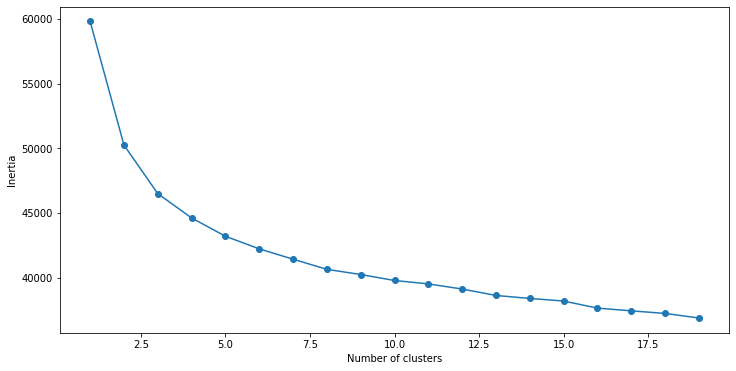

In [9]:
SSE = []
for cluster in range(1,20):
    kmeans = KMeans(n_jobs = -1, n_clusters = cluster, init='k-means++')
    kmeans.fit(corpus_embeddings)
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,20), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [10]:
num_clusters = 5
clustering_model = KMeans(n_clusters=num_clusters)
clustering_model.fit(corpus_embeddings)
cluster_assignment = clustering_model.labels_

clustered_sentences = [[] for i in range(num_clusters)]
for sentence_id, cluster_id in enumerate(cluster_assignment):
    clustered_sentences[cluster_id].append(titles[sentence_id])
    
for i, cluster in enumerate(clustered_sentences):
    print("Cluster ", i+1)
    print(cluster)
    print("")

Cluster  1
['Conservation of the biodiversity of the Nimba Mountains through integrated and participatory management', 'Conservation and Monitoring of Globally Significant Birds and Bird Habitats in the West Arabian Flyway', 'C.A.P.E Agulhas Biodiversity Initiative (ABI)', 'C.A.P.E. Biodiversity Conservation and Sustainable Development', 'Stabilizing Rural Populations Through the Identification of Systems for Sustainable Management and Local Governance of Lands in Southern Madagascar', 'Securing livelihoods, Conservation, Sustainable Use and Restoration of high range Himalayan Ecosystems (SECURE) Himalayas', 'Designing and Implementing a National Sub-System of Marine Protected Areas (SMPA) in Colombia', 'Increased Resilience and Adaptation to Adverse Impacts of Climate Change in Guinea\x92s Vulnerable Coastal Zones', 'Network of Managed Resource Protected Areas', 'Sustainable Management of the Mbe River Forested Watershed through the Development of a Payments for Ecosystem Services (PE

In [11]:
frame = pd.DataFrame(corpus)
frame['cluster'] = cluster_assignment
frame['cluster'].value_counts()

4    125
2    120
1    114
0    105
3     29
Name: cluster, dtype: int64

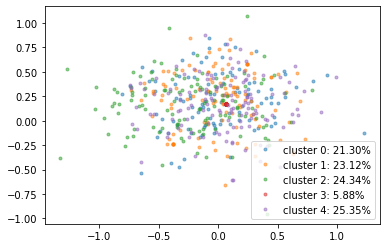

In [12]:
viz.plot_proj(corpus_embeddings, cluster_assignment)

## Semantic Search


This is a simple application for sentence embeddings: semantic search
We have a corpus with various sentences. Then, for a given query sentence,
we want to find the most similar sentence in this corpus.
This script outputs for various queries the top 5 most similar sentences in the corpus.


In [ ]:
from sentence_transformers import SentenceTransformer, util
import torch

model = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')

# Corpus with example sentences
corpus = features_only['project_description'].tolist()
title =features_only['title_x'].tolist()
for i in range(len(corpus)):
        corpus[i] = str(corpus[i])
corpus_embeddings = model.encode(corpus, convert_to_tensor=True)

# Query sentences:
queries = ['agriculture and tourism sectors', 'The Cape Floristic Region (CFR) Biodiversity Hotspot', 'The Niger Delta region of Nigeria']


# Find the closest 5 sentences of the corpus for each query sentence based on cosine similarity
top_k = 5
for query in queries:
    query_embedding = model.encode(query, convert_to_tensor=True)
    cos_scores = util.pytorch_cos_sim(query_embedding, corpus_embeddings)[0]
    cos_scores = cos_scores.cpu()

    #We use torch.topk to find the highest 5 scores
    top_results = torch.topk(cos_scores, k=top_k)

    print("\n\n======================\n\n")
    print("Query:", query)
    print("\nTop 5 most similar sentences in corpus:")
    print("\n")

    for score, idx in zip(top_results[0], top_results[1]):
        print("- "+title[idx], "(Score: %.4f)" % (score))

## Topic modeling ( In progress)

In [ ]:
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel

def tokenize(docs):
    return

data = tokenize(features_only['project_description'])

# Create Dictionary
id2word = corpora.Dictionary(data)

# Create Corpus
texts = data

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=6, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,

import pyLDAvis
import pyLDAvis.gensim  

vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis